# Практическая работа №1 
## по предмету "Системы искусственного интеллекта"
### БВТ2101 Юдин Артём

В данной практической работе Вы будете работать с базой данных, посвященной баскетболу, которая включает в себя информацию об игроках, играх и командах. 


### Задание 1
Вам необходимо запустить в docker базу данных PostgreSQL и выгрузить туда все данные из файла nba.sqlite, приложенного к лабороторной работе.
Выгрузить данные можно с помощью утилиты pgloader (https://pgloader.readthedocs.io/en/latest/ref/sqlite.html)

In [1]:
import polars as pl
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# import sqlite3
# connector = sqlite3.connect("nba.sqlite")
# df = pl.read_sql_query("SELECT * FROM {table_name}", connector)

### Задание 2

Загрузите данные из таблицы game. Посмотрите, какие есть типы игр в сезоне (season_type) и количество этих игр.

season_type,len
str,u32
"""Regular Season""",60192
"""Playoffs""",3842
"""All-Star""",63
"""All Star""",65
"""Pre Season""",1536


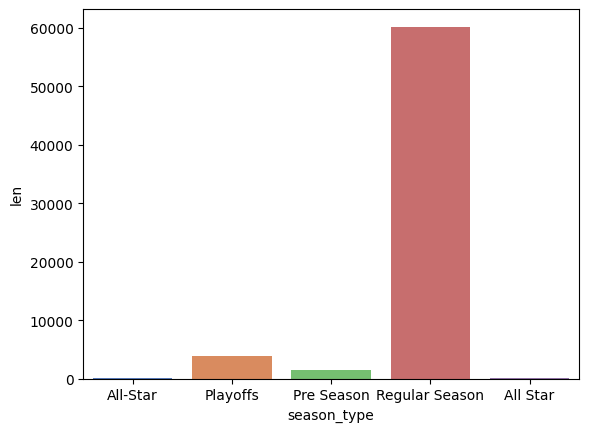

In [176]:
df = pl.read_csv("../csv/game.csv")

sns.barplot(data=df.group_by('season_type').len(),
            x="season_type",
            y="len",
            hue="season_type",
            palette="muted")

df.group_by('season_type').len()

Нам понадобятся только регулярные игры сезона и play-off. Отделите эти игры в новый датафрейм.

In [177]:
df = df.filter(pl.col("season_type").eq("Regular Season"))
df.head()

,season_id,team_id_home,team_abbreviation_home,team_name_home,game_id,game_date,matchup_home,wl_home,min,fgm_home,fga_home,fg_pct_home,fg3m_home,fg3a_home,fg3_pct_home,ftm_home,fta_home,ft_pct_home,oreb_home,dreb_home,reb_home,ast_home,stl_home,blk_home,tov_home,pf_home,pts_home,plus_minus_home,video_available_home,team_id_away,team_abbreviation_away,team_name_away,matchup_away,wl_away,fgm_away,fga_away,fg_pct_away,fg3m_away,fg3a_away,fg3_pct_away,ftm_away,fta_away,ft_pct_away,oreb_away,dreb_away,reb_away,ast_away,stl_away,blk_away,tov_away,pf_away,pts_away,plus_minus_away,video_available_away,season_type
i64,i64,i64,str,str,i64,str,str,str,i64,f64,f64,f64,str,str,str,f64,f64,f64,str,str,str,str,str,str,str,f64,f64,i64,i64,i64,str,str,str,str,f64,f64,f64,str,str,str,f64,f64,f64,str,str,str,str,str,str,str,f64,f64,i64,i64,str
0,21946,1610610035,"""HUS""","""Toronto Huskies""",24600001,"""1946-11-01 00:00:00""","""HUS vs. NYK""","""L""",0,25.0,null,null,null,null,null,16.0,29.0,0.552,null,null,null,null,null,null,null,null,66.0,-2,0,1610612752,"""NYK""","""New York Knicks""","""NYK @ HUS""","""W""",24.0,null,null,null,null,null,20.0,26.0,0.769,null,null,null,null,null,null,null,null,68.0,2,0,"""Regular Season"""
1,21946,1610610034,"""BOM""","""St. Louis Bombers""",24600003,"""1946-11-02 00:00:00""","""BOM vs. PIT""","""W""",0,20.0,59.0,0.339,null,null,null,16.0,null,null,null,null,null,null,null,null,null,21.0,56.0,5,0,1610610031,"""PIT""","""Pittsburgh Ironmen""","""PIT @ BOM""","""L""",16.0,72.0,0.222,null,null,null,19.0,null,null,null,null,null,null,null,null,null,25.0,51.0,-5,0,"""Regular Season"""
2,21946,1610610032,"""PRO""","""Providence Steamrollers""",24600002,"""1946-11-02 00:00:00""","""PRO vs. BOS""","""W""",0,21.0,null,null,null,null,null,17.0,null,null,null,null,null,null,null,null,null,null,59.0,6,0,1610612738,"""BOS""","""Boston Celtics""","""BOS @ PRO""","""L""",21.0,null,null,null,null,null,11.0,null,null,null,null,null,null,null,null,null,null,53.0,-6,0,"""Regular Season"""
3,21946,1610610025,"""CHS""","""Chicago Stags""",24600004,"""1946-11-02 00:00:00""","""CHS vs. NYK""","""W""",0,21.0,null,null,null,null,null,21.0,null,null,null,null,null,null,null,null,null,20.0,63.0,16,0,1610612752,"""NYK""","""New York Knicks""","""NYK @ CHS""","""L""",16.0,null,null,null,null,null,15.0,null,null,null,null,null,null,null,null,null,22.0,47.0,-16,0,"""Regular Season"""
4,21946,1610610028,"""DEF""","""Detroit Falcons""",24600005,"""1946-11-02 00:00:00""","""DEF vs. WAS""","""L""",0,10.0,null,null,null,null,null,13.0,null,null,null,null,null,null,null,null,null,null,33.0,-17,0,1610610036,"""WAS""","""Washington Capitols""","""WAS @ DEF""","""W""",18.0,null,null,null,null,null,14.0,null,null,null,null,null,null,null,null,null,null,50.0,17,0,"""Regular Season"""


В датах игр выделите только год, убрав день и месяц, в которых была проведена игра

In [178]:
df = df.with_columns(
    pl.col("game_date").map_elements(lambda s: int(s[:4]), return_dtype=int).alias("game_year")
)
df.group_by("game_year").len()

game_year,len
i64,u32
1983,946
1971,325
1989,1059
1974,680
1980,926
…,…
1959,297
1962,165
1950,479


Нас интересует общий счет, поэтому уберите столбцы pts_home и pts_away, заменив их стобцом с их суммой

In [179]:
df = df.with_columns(
    pl.col("pts_home").add(pl.col("pts_away")).alias("pts_total")
)
df.select(pl.col("pts_home"), pl.col("pts_away"), pl.col("pts_total"))

pts_home,pts_away,pts_total
f64,f64,f64
66.0,68.0,134.0
56.0,51.0,107.0
59.0,53.0,112.0
63.0,47.0,110.0
33.0,50.0,83.0
…,…,…
136.0,141.0,277.0
105.0,134.0,239.0
103.0,81.0,184.0


Постройте график, где по оси Х будет год игр, а по оси Y - среднее количество очков за игру в этом году.

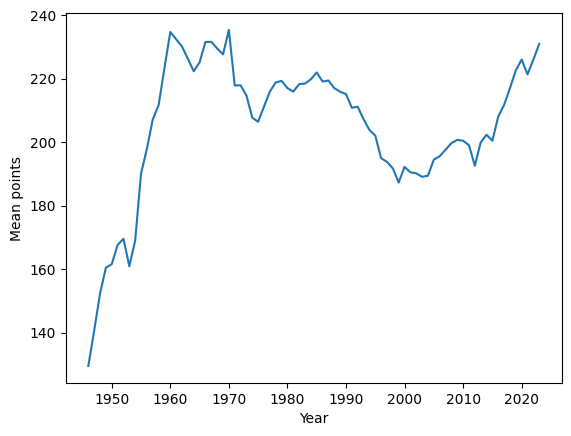

In [180]:
df_grouped = df.group_by("game_year").mean()
df_grouped = df_grouped.sort(by="game_year")
plt.plot(df_grouped.select(pl.col('game_year')), df_grouped.select(pl.col('pts_total')))
plt.ylabel('Mean points')
plt.xlabel('Year')
plt.show()

### Задание 3

Выполните запрос к таблице draft_history, получив датафрейм.

In [181]:
df = pl.read_csv("../csv/draft_history.csv")
df.head()

,person_id,player_name,season,round_number,round_pick,overall_pick,draft_type,team_id,team_city,team_name,team_abbreviation,organization,organization_type,player_profile_flag
i64,i64,str,i64,i64,i64,i64,str,i64,str,str,str,str,str,i64
0,79299,"""Clifton McNeeley""",1947,1,1,1,"""Draft""",1610610031,"""Pittsburgh""","""Ironmen""","""PIT""","""Texas-El Paso""","""College/University""",0
1,78109,"""Glen Selbo""",1947,1,2,2,"""Draft""",1610610035,"""Toronto""","""Huskies""","""HUS""","""Wisconsin""","""College/University""",1
2,76649,"""Eddie Ehlers""",1947,1,3,3,"""Draft""",1610612738,"""Boston""","""Celtics""","""BOS""","""Purdue""","""College/University""",1
3,79302,"""Walt Dropo""",1947,1,4,4,"""Draft""",1610610032,"""Providence""","""Steamrollers""","""PRO""","""Connecticut""","""College/University""",0
4,77048,"""Dick Holub""",1947,1,5,5,"""Draft""",1610612752,"""New York""","""Knicks""","""NYK""","""Long Island-Brooklyn""","""College/University""",1


Постройте график, где по оси X будет год, а по оси Y - количество выбранных игроков в этот год (каждая строка в таблице - выбранный игрок).

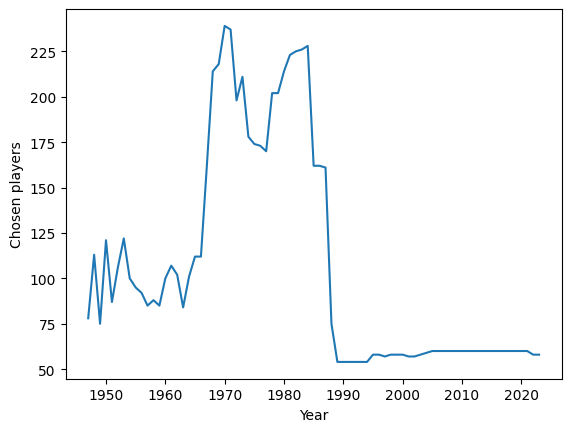

In [182]:
df_grouped = df.group_by("season").len()
df_grouped = df_grouped.sort(by="season")
plt.plot(df_grouped.select(pl.col('season')), df_grouped.select(pl.col('len')))
plt.ylabel('Chosen players')
plt.xlabel('Year')
plt.show()

### Задание 4

Необходимо построить график, показывающий топ 10 школ, игроки из которых были выбраны. Для этого вам понадобятся таблицы common_player_info и draft_history.

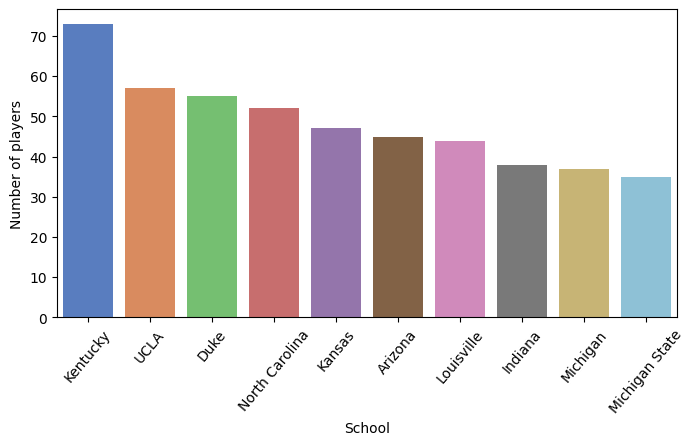

In [183]:
df1 = pd.read_csv("../csv/common_player_info.csv")
df2 = pd.read_csv("../csv/draft_history.csv")

df_merged = pd.merge(df2[['person_id']], df1[['person_id', 'school']], on='person_id', how='inner')
df_merged = df_merged['school'].value_counts().sort_values(ascending=False)

plt.figure(figsize=(8,4))
sns.barplot(x=df_merged.index[:10],
            y=df_merged.iloc[:10],
            hue=df_merged.index[:10],
            palette="muted")
plt.ylabel('Number of players')
plt.xlabel('School')
plt.xticks(rotation=50)
plt.show()

### Задание 5

Постройте график сравнения выигранных домашних и выездных игр в каждом году. Для этого используйте таблицу game.

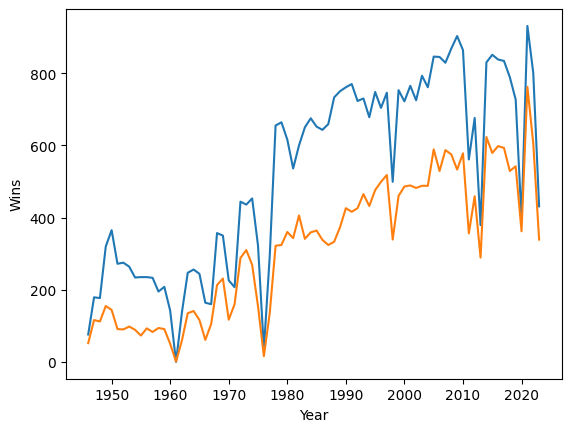

In [184]:
df = pl.read_csv("../csv/game.csv")

df = df.with_columns(
    pl.col("wl_home")=="W",
    pl.col("wl_away")=="W",
    pl.col("game_date").map_elements(lambda s: int(s[:4]), return_dtype=int)
)
wl = df.group_by("game_date").agg(pl.col("wl_home").sum(), pl.col("wl_away").sum()).sort(by="game_date")
plt.plot(wl.select(pl.col("game_date")), wl.select(pl.col("wl_home")), label="Wins home")
plt.plot(wl.select(pl.col("game_date")), wl.select(pl.col("wl_away")), label="Wins away")
plt.xlabel("Year")
plt.ylabel("Wins")
plt.show()

### Задание 6

Какова средняя продолжительность карьеры активного игрока NBA? Используйте таблицы common_player_info и player. Активный игрок - это тот, у которого в колонке is_active стоит 1.

In [185]:
df_players = pd.read_csv("../csv/player.csv")
df_player_infos = pd.read_csv("../csv/common_player_info.csv")

df_player_infos = pd.merge(df_player_infos.rename(columns={'display_first_last':'full_name'}), df_players[['full_name', 'is_active']], on=['full_name'], how='inner')
df_active = df_player_infos[df_player_infos['is_active'] == 1]

df_active['career_duration'] = df_active['to_year'].to_numpy() - df_active['from_year'].to_numpy()
print(f"Mean duration of players' career is {round(df_active['career_duration'].mean(), 2)} years")

Mean duration of players' career is 5.13 years


C:\Users\Артём\AppData\Local\Temp\ipykernel_25204\1133039544.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_active['career_duration'] = df_active['to_year'].to_numpy() - df_active['from_year'].to_numpy()


### Задание 7

Каково соотношение позиций, на которых играют игроки? Используйте таблицу common_player_info.

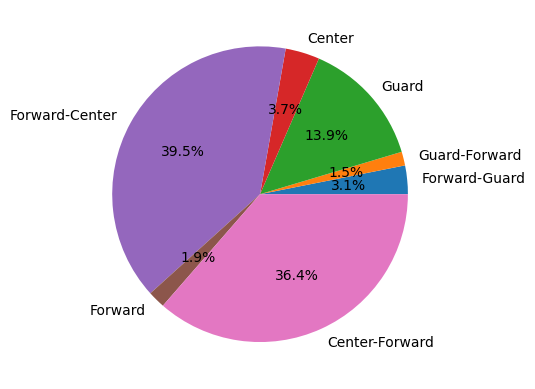

In [191]:
df = pl.read_csv("../csv/common_player_info.csv")
plt.pie(df.group_by("position").len().drop_nulls()["len"], 
        labels=df.group_by("position").len().drop_nulls()["position"], 
        autopct='%1.1f%%')
plt.show()